In [1]:
from scipy.spatial import distance
import sys
import os
import cv2
import numpy as np
import torch
import dlib
from imutils import face_utils
from basicsr.archs.rrdbnet_arch import RRDBNet
from basicsr.utils.download_util import load_file_from_url
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import Dataset
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn.functional as F
import math
import time
from imutils import face_utils
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import mediapipe

import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append("../LuminEye-MainPipeLine/")
# device = "cpu"


In [2]:

# # Load Model 256
model_U = torch.load(
    "/home/nipun/Documents/Uni_Malta/LuminEye/LuminEye-Experiments/U2net/U2NET_MULTICLASS_IMG_256_DIC_batch_8/Miche_model_2023_04_11_22:14:26_val_iou0.900.pt", map_location=device)


model_U.eval()

RESIZE_AMT = 256


In [3]:
# BioID
val_csv_path = "/home/nipun/Documents/Uni_Malta/Datasets/CenterRegression/BIOID/BioIDCentersval.csv"


val_df = pd.read_csv(val_csv_path)


# validation_img_names = [name+".pgm" for name in list(val_df["SourceImage"])]

# print(validation_img_names )


In [4]:
x= [1,2,3,4,5,6]



In [5]:
def selectImgDir(datasetType: str):

    if datasetType == "MP2GAZE":
        return "/home/nipun/Documents/Uni_Malta/Datasets/"

    elif datasetType == "i2head":
        return "/home/nipun/Documents/Uni_Malta/Datasets/"

    elif datasetType == "GI4E":

        return "/home/nipun/Documents/Uni_Malta/Datasets/gi4e_database/images/"


In [6]:
detector = None
predictor = None
GAN_MODEL = None
IRIS_MODEL = None
EYE_AR_THRESH = 0.2

mp_face_mesh = mediapipe.solutions.face_mesh

face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [7]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


In [8]:
def captureFaceLandmarks(frame):

    results = face_mesh.process(frame)
    landmarks = results.multi_face_landmarks[0]

    shape_arr = []

    for landmark in landmarks.landmark:

        x = landmark.x
        y = landmark.y

        relative_x = int(x * frame.shape[1])
        relative_y = int(y * frame.shape[0])

        shape_arr.append([relative_x, relative_y])

    return np.array(shape_arr)


In [9]:

# BIOID
padded_amt = 15


In [10]:
def cropped_image(img, shape_array, padded_amt=padded_amt):
    """Cropped eye region 

    Args:
        img (__numpy__): _Original Image_
        shape_array (_numpy_): _FaceLandMark locations_
        padded_amt (int, optional): _padding size_. Defaults to 15.

    """

    Leye = {"top_left": shape_array[70], "bottom_right": shape_array[133]}

    Reye = {"top_left": shape_array[285],
            "bottom_right": shape_array[263]}

    left_eye = img[Leye["top_left"][1]:Leye["bottom_right"][1] +
                   padded_amt, Leye["top_left"][0]:Leye["bottom_right"][0]]

    right_eye = img[Reye["top_left"][1]:Reye["bottom_right"][1] +
                    padded_amt, Reye["top_left"][0]:Reye["bottom_right"][0]]

    return left_eye, right_eye, Leye, Reye


In [11]:

def rescale_coordinate(coord, original_image, resize_amt):

    h, w = original_image.shape[:2]
    coord[0] = int((coord[0]/resize_amt) * w)
    coord[1] = int((coord[1]/resize_amt) * h)

    return coord


In [12]:
def mpArrayToNumpy(landmark_array, img):

    shape_arr = []

    for landmark in landmark_array.landmark:
        x = landmark.x
        y = landmark.y

        relative_x = int(x * img.shape[1])
        relative_y = int(y * img.shape[0])

        shape_arr.append([relative_x, relative_y])

    return np.array(shape_arr)


In [13]:

# BioId
IMG_DIR = "/home/nipun/Documents/Uni_Malta/Datasets/BioID-FaceDatabase-V1.2/images/"


In [14]:
text_dir_path = "/home/nipun/Documents/Uni_Malta/Datasets/BioID-FaceDatabase-V1.2/labels/"


In [15]:
def scaleCoorinatesToOriginalImage(pred_coords, eye_margin):

    # {'top_left': array([385, 214]), 'bottom_right': array([426, 226])}

    x1 = eye_margin["top_left"][0] + pred_coords[0]
    y1 = eye_margin["top_left"][1] + pred_coords[1]

    return [x1, y1]


In [16]:
def calculateEuclideanDistance(coord1, coord2):
    return (((coord1[0])-float(coord2[0])) ^ 2 + (float(coord1[0])-float(coord2[0])) ^ 2) ^ 0.5


In [17]:
val_df.head()


,Unnamed: 0,SourceImage,Image_Name,X1,Y1
0,0,BioID_0002,BioID_0002_left.png,0.605263,0.461538
1,1,BioID_0002,BioID_0002_right.png,0.636364,0.500000
2,2,BioID_0010,BioID_0010_left.png,0.604167,0.485714
3,3,BioID_0010,BioID_0010_right.png,0.585366,0.423077
4,4,BioID_0018,BioID_0018_left.png,0.634615,0.482759


In [18]:
img_names = list(val_df["SourceImage"])


In [19]:
def imgTransform(image):
    """ Transform numpy images to Torch tensors

    Args:
        image (_numpy_): _cropped_eye_region_
        resize_amt (_int_): _Input Resize for the image_

    Returns:
        _torch.float32_: _Transformed image tensor_
    """

    transform = A.Compose([
        A.Resize(RESIZE_AMT, RESIZE_AMT),
        A.augmentations.transforms.Normalize(
            mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2()
    ])

    return transform(image=image)["image"]


In [20]:
def predict_image_masku2net(model, image):

    image = imgTransform(image[:, :, ::-1])

    image = image.to(device)

    with torch.no_grad():

        softmax = nn.Softmax(dim=1)
        image = image.unsqueeze(0)

        model_output, _, _, _, _, _, _ = model(image)

        output = softmax(model_output)

        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked


In [21]:
def decode_segmap(temp, n_classes=3):

    colors = [[0,   0,   0], [0, 255, 0], [0, 0, 255]]
    label_colours = dict(zip(range(n_classes), colors))
    # convert gray scale to color
    temp = temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb


In [22]:
def imageCenterFromConnectedComponent(img, connectivity=4):

    pred_image = decode_segmap(img) * 255

    grayscale_mask = np.argmax(pred_image, axis=-1).astype(np.uint8)

    analysis = cv2.connectedComponentsWithStats(grayscale_mask,
                                                connectivity,
                                                cv2.CV_32S)
    (totalLabels, label_ids, values, centroid) = analysis

    return centroid


In [23]:
def findCentersMoments(pred_mask,eye_w,eye_h,margin):
    
    pred_image = decode_segmap(pred_mask) * 255
    pred_image = pred_image.astype(np.uint8)
    edge_detected_image = cv2.Canny(pred_image, 0, 200)
    
    contours, hierarchy = cv2.findContours(edge_detected_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    
    
    
    cnt = max(contours, key = cv2.contourArea) # finding contour with #maximum area
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    
    ori_cx = int(margin["top_left"][0] +((cx/RESIZE_AMT ) * eye_w))
    ori_cy = int(margin["top_left"][1] + ((cy/RESIZE_AMT ) * eye_h))
    
  
    
    return [ori_cx,ori_cy]

In [24]:

maximizedNormalizedError = []

count = 0
for name in img_names:

    img_path = os.path.join(IMG_DIR, name+".pgm")

    text_path = os.path.join(text_dir_path, name+".eye")

    with open(text_path, "r") as f:

        data = f.readlines()[-1].rstrip().split("\t")

    right_center = [float(num) for num in data[:2]]
    left_center = [float(num) for num in data[2:]]

    IPD = distance.euclidean(left_center, right_center)

    img = cv2.imread(img_path)
    
    
    cropped_img = img.copy()

    results = face_mesh.process(img)

    if results.multi_face_landmarks is not None:
        landmarks = results.multi_face_landmarks[0]

        shape_arr = mpArrayToNumpy(landmarks, img)
        
        
       


        left_eye, right_eye, Leye, Reye = cropped_image(cropped_img, shape_arr)

        pred_l_eye, pred_r_eye = predict_image_masku2net(
            model_U, left_eye), predict_image_masku2net(model_U, right_eye)
        
        
        left_centroid = imageCenterFromConnectedComponent(pred_l_eye)[-1]
        right_centroid = imageCenterFromConnectedComponent(pred_r_eye)[-1]
        
        
        
        
        

        pred_l_eye_center = rescale_coordinate(left_centroid, left_eye, RESIZE_AMT)

        pred_r_eye_center = rescale_coordinate(right_centroid, right_eye, RESIZE_AMT)

        
        
        
        
        
        
        
        
        # cv2.circle(left_eye, (int(pred_l_eye_center[0]), int(
        #     pred_l_eye_center[1])), 1, (0, 255, 0), -1)

        # cv2.circle(right_eye, (int(pred_r_eye_center[0]), int(
        #     pred_r_eye_center[1])), 1, (0, 255, 0), -1)
        

        # fig, axes = plt.subplots(2, 2)

        # fig.set_figheight(8)
        # fig.set_figwidth(8)

        # axes[0][0].imshow(left_eye)
        # axes[0][1].imshow(pred_l_eye)

        # axes[1][0].imshow(right_eye)
        # axes[1][1].imshow(pred_r_eye)

        # count += 1
        # if count == 5:
        #     break

        
        pred_l_eye_toOriginaImage = scaleCoorinatesToOriginalImage(
            pred_l_eye_center, Leye)
        pred_r_eye_toOriginaImage = scaleCoorinatesToOriginalImage(
            pred_r_eye_center, Reye)
        
        

        # # print(pred_l_eye_toOriginaImage)
        # # print(coords[2:4])

        cv2.circle(img, (int(pred_l_eye_toOriginaImage[0]), int(
            pred_l_eye_toOriginaImage[1])), 1, (0, 255, 0), -1)

        cv2.circle(img, (int(pred_r_eye_toOriginaImage[0]), int(
            pred_r_eye_toOriginaImage[1])), 1, (0, 255, 0), -1)
        
        
        
        cv2.circle(img, (int(left_center[0]), int(
            left_center[1])), 1, (0, 0, 255), -1)

        cv2.circle(img, (int(right_center[0]), int(
            right_center[1])), 1, (0, 0, 255), -1)
        
        
        # plt.figure(figsize=(10,10))
        # plt.imshow(img[:,:,::-1])
        # plt.show()

        left_eye_euclidea_distance = distance.euclidean(
            pred_l_eye_toOriginaImage, left_center)

        right_eye_euclidea_distance = distance.euclidean(
            pred_r_eye_toOriginaImage, right_center)

        eMax = max(left_eye_euclidea_distance, right_eye_euclidea_distance)/IPD

        print(eMax)

        maximizedNormalizedError.append(eMax)

   

    else:

        print(
            f"MediaPipe was failed to detect the faces on the image name {obj[0]}")
        continue

    # break


/home/nipun/.local/lib/python3.10/site-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


0.04583011101693304
0.04583011101693304
0.018077538151554683
0.018077538151554683
0.026004306669806312
0.026004306669806312
0.01492371097349751
0.01492371097349751
0.020788268748151588
0.020788268748151588
0.024350440792625046
0.024350440792625046
0.02523772325625344
0.02523772325625344
0.026664296612298865
0.026664296612298865
0.019198845032223247
0.019198845032223247
0.018467921378827943
0.018467921378827943
0.019216561050602196
0.019216561050602196
0.05660377358490566
0.05660377358490566
0.016251034766798112
0.016251034766798112
0.024820697574658462
0.024820697574658462
0.03952538295217408
0.03952538295217408
0.017246506858208478
0.017246506858208478
0.026932760114537175
0.026932760114537175
0.03288868749704872
0.03288868749704872
0.01233065307765875
0.01233065307765875
0.016581673118850265
0.016581673118850265
0.016994371546483495
0.016994371546483495
0.017007884982457738
0.017007884982457738
0.0
0.0
0.0282786160897032
0.0282786160897032
0.031189143077590267
0.031189143077590267
0.

In [25]:
def CheckForLess(list1, val):

    l1 = []
    for x in list1:

        if x <= val:
            l1.append(x)
    return l1


In [26]:
e_0_25 = CheckForLess(maximizedNormalizedError, 0.15)

e_0_1 = CheckForLess(maximizedNormalizedError, 0.10)

e_0_05 = CheckForLess(maximizedNormalizedError, 0.05)

e_0_025 = CheckForLess(maximizedNormalizedError, 0.025)


In [27]:
(len(e_0_25)/len(maximizedNormalizedError)) * 100


96.7930029154519

In [28]:
(len(e_0_05)/len(maximizedNormalizedError)) * 100


52.1865889212828

In [29]:
len(e_0_1)/len((maximizedNormalizedError)) * 100


93.29446064139941

In [30]:
len(e_0_025)/len((maximizedNormalizedError)) * 100

19.24198250728863

: 

In [44]:
# (sum(list((i<=0.25 for i in maximizedNormalizedError))))/len(maximizedNormalizedError) * 100

99.12536443148689

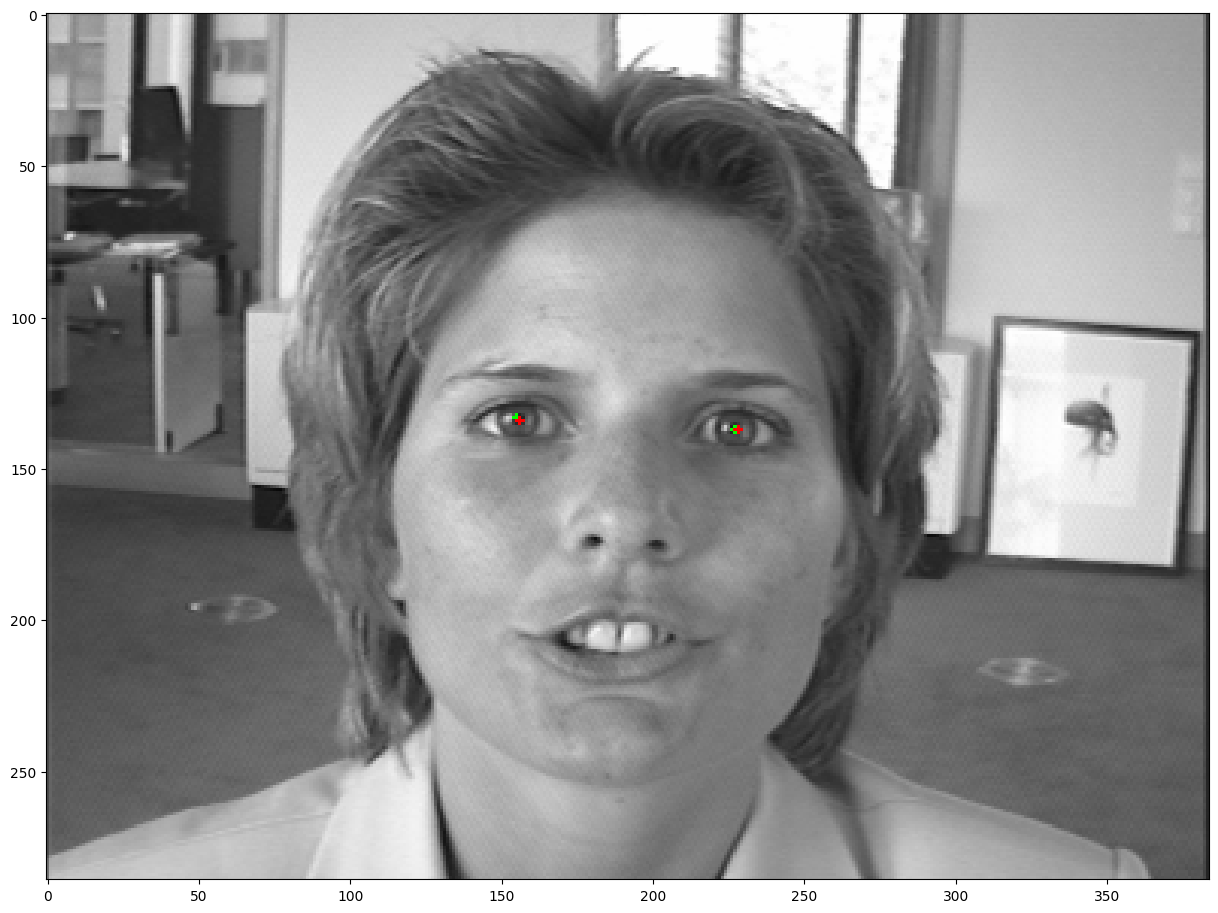

In [30]:
plt.figure(figsize=(15, 15))
plt.imshow(img[:, :, ::-1])


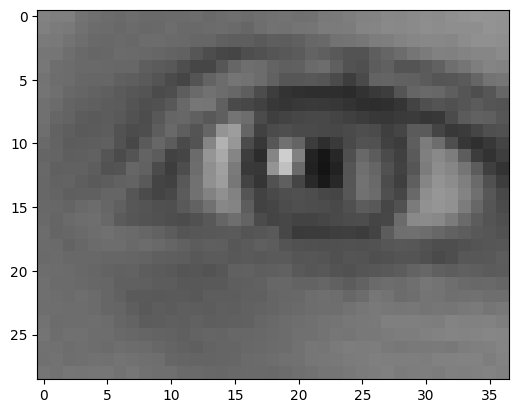

: 

In [31]:
plt.imshow(right_eye)


In [ ]:
img_path = "/home/nipun/Documents/Uni_Malta/Datasets/columbia_gaze_data_set/Columbia Gaze Data Set/0039/0039_2m_0P_10V_5H.jpg"

frame = cv2.imread(img_path)

plt.imshow(frame[:, :, ::-1])


In [ ]:
# MediaPipe
shape_array = captureFaceLandmarks(frame)


In [ ]:
left_eye, right_eye, Leye, Reye = cropped_image(frame, shape_array)


In [ ]:
plt.imshow(left_eye[:, :, ::-1])


In [ ]:
plt.imshow(right_eye[:, :, ::-1])


In [ ]:
# left = "/home/nipun/Documents/Uni_Malta/Datasets/Center_Regression/MP2GAZE/Images/417_left.png"

# left_eye = cv2.imread(left)


In [ ]:
_, pred_l_eye = prediction_image(model=REGRESSION_MODEL, image=left_eye)


_, pred_r_eye = prediction_image(model=REGRESSION_MODEL, image=right_eye)


pred_l_eye = rescale_coordinate(pred_l_eye, left_eye, RESIZE_AMT)

pred_r_eye = rescale_coordinate(pred_r_eye, right_eye, RESIZE_AMT)


In [ ]:
cv2.circle(left_eye, (int(pred_l_eye[0]), int(
    pred_l_eye[1])), 1, (0, 255, 0), -1)
cv2.circle(right_eye, (int(pred_r_eye[0]), int(
    pred_r_eye[1])), 1, (0, 255, 0), -1)


In [ ]:
plt.imshow(left_eye[:, :, ::-1])


In [ ]:
plt.imshow(right_eye[:, :, ::-1])
